In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [10]:
# --- 1. LLG 求解器 (保持不变) ---
# 物理参数
alpha = 0.02
gamma = 1.7e7 / 1e9
H_ext = 200.0
H_deg = 8400.0
omega_ac_GHz = 32.0
omega_ac = omega_ac_GHz * 2 * np.pi
a_ac = 26.0
e_x = np.array([1.0, 0.0, 0.0])
e_z = np.array([0.0, 0.0, 1.0])

def llg_solver(input_sequence, t_duration, t_points=1000):
    """
    接收一个二进制输入序列，运行LLG模拟。
    """
    input_width = 10 # 每个输入持续10ns
  
    def get_aj(t):
        idx = int(t // input_width)
        if idx >= len(input_sequence):
            idx = len(input_sequence) - 1
        a_dc = 100.0 if input_sequence[idx] == 0 else 200.0
        return a_dc + a_ac * np.cos(omega_ac * t)

    def llg_equation(t, m):
        m = m / np.linalg.norm(m)
        H_eff = H_ext * e_x - H_deg * m[2] * e_z
        a_j_t = get_aj(t)
        T_field = -gamma * np.cross(m, H_eff)
        T_stt = gamma * a_j_t * np.cross(m, np.cross(m, e_x))
        T_total = T_field + T_stt
        dmdt = (1 / (1 + alpha**2)) * (T_total + alpha * np.cross(m, T_total))
        return dmdt

    m0 = np.array([0.9, 0.1, 0.1])
    m0 = m0 / np.linalg.norm(m0)
    t_span = [0, t_duration]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
  
    sol = solve_ivp(
        llg_equation, t_span, m0, method='LSODA', t_eval=t_eval
    )
    return sol.t, sol.y[2]


In [11]:
# --- 2. 数据生成与状态提取 (修改版) ---
def generate_dataset(num_samples, input_len=5):
    """
    生成用于训练的数据集。
    input_len: 0-50ns 内的输入数量，现在是5个。
    """
    dataset = []
    simulation_duration = 60 # 模拟总时长为 60ns
    simulation_points = int(simulation_duration * 10 + 1) # 确保采样精度
    sampling_start_time = 50 # 从 50ns 开始采样
    sampling_end_time = 60   # 到 60ns 结束采样
  
    print(f"正在生成 {num_samples} 组训练数据 (输入长度: {input_len})...")
    for _ in tqdm(range(num_samples)):
        # 随机生成 0-50ns 的输入序列 (5个二进制位)
        target_inputs = np.random.randint(0, 2, size=input_len)
      
        # 运行模拟
        t, mz = llg_solver(target_inputs, t_duration=simulation_duration, t_points=simulation_points)
      
        # 提取储备池状态：对 50ns 到 60ns 的 mz 进行采样
        start_time_idx = np.where(t >= sampling_start_time)[0][0]
        end_time_idx = np.where(t >= sampling_end_time)[0][0]
      
        # 每隔 1ns 采一个样 (10个点)
        reservoir_states = mz[start_time_idx:end_time_idx+1:10]
      
        # 确保我们采样了正确数量的点
        if len(reservoir_states) != 11: # 50, 51, ..., 60 共11个点
             continue # 如果由于数值误差导致点数不对，跳过此样本

        dataset.append((reservoir_states, target_inputs))
      
    return dataset

In [12]:
# --- 3. 线性解码器和训练 (保持不变) ---
class LinearDecoder:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size) * 0.01
        self.bias = np.zeros(output_size)
      
    def predict(self, x):
        return np.dot(self.weights, x) + self.bias

    def train_sgd(self, dataset, learning_rate=0.001, epochs=100):
        loss_history = []
        for epoch in range(epochs):
            total_loss = 0
            np.random.shuffle(dataset)
          
            for x, y_true in dataset:
                y_pred = self.predict(x)
                error = y_pred - y_true
                loss = np.mean(error**2)
                total_loss += loss
              
                grad_weights = 2 * np.outer(error, x)
                grad_bias = 2 * error
              
                self.weights -= learning_rate * grad_weights
                self.bias -= learning_rate * grad_bias
              
            avg_loss = total_loss / len(dataset)
            loss_history.append(avg_loss)
            if (epoch + 1) % 20 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
        return loss_history

正在生成 2000 组训练数据 (输入长度: 5)...


100%|██████████| 2000/2000 [40:56<00:00,  1.23s/it]



开始训练解码器...
Epoch [20/200], Loss: 0.157981
Epoch [40/200], Loss: 0.147492
Epoch [60/200], Loss: 0.143458
Epoch [80/200], Loss: 0.141685
Epoch [100/200], Loss: 0.140718
Epoch [120/200], Loss: 0.140168
Epoch [140/200], Loss: 0.139886
Epoch [160/200], Loss: 0.139739
Epoch [180/200], Loss: 0.139605
Epoch [200/200], Loss: 0.139575


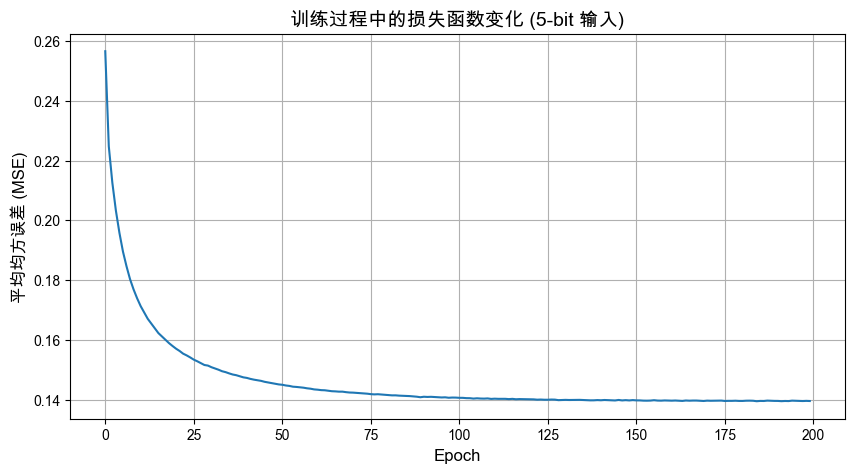

In [ ]:
# --- 4. 主程序：生成数据、训练和评估 (修改版) ---
# 生成数据集
num_train_samples = 2000 # 增加训练样本数量，因为任务更复杂
input_length = 5 # 5个二进制输入
dataset = generate_dataset(num_train_samples, input_len=input_length)

# 初始化解码器
reservoir_size = dataset[0][0].shape[0]
output_size = input_length
decoder = LinearDecoder(input_size=reservoir_size, output_size=output_size)

# 训练解码器
print("\n开始训练解码器...")
# 可能需要调整学习率和增加epochs
loss_hist = decoder.train_sgd(dataset, learning_rate=0.002, epochs=200)

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(loss_hist)
plt.title('训练过程中的损失函数变化 (5-bit 输入)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('平均均方误差 (MSE)', fontsize=12)
plt.grid(True)
plt.show()


开始评估解码器...
测试用的真实输入 (0-50ns): [1 1 0 1 1]
解码器预测的连续值: [0.7552656  0.77685715 0.17553833 0.60652933 1.26545595]
解码器预测的二进制值: [1 1 0 1 1]
解码准确率: 100.00%
解码完全成功！


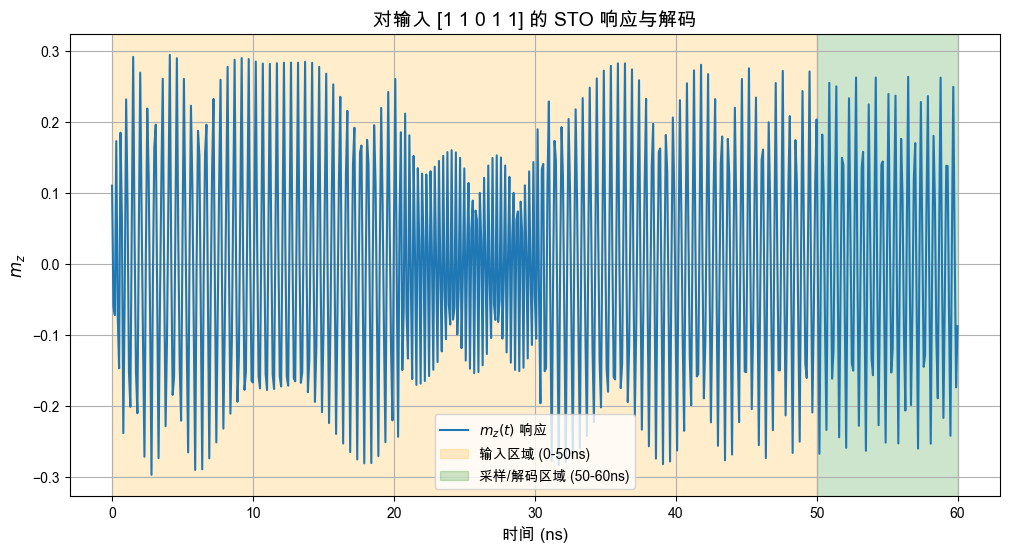

In [ ]:
# --- 5. 评估解码器性能 ---
print("\n开始评估解码器...")
# 生成一个全新的测试样本
test_input = np.random.randint(0, 2, size=input_length)
print(f"测试用的真实输入 (0-50ns): {test_input}")

# 运行模拟
t_test, mz_test = llg_solver(test_input, t_duration=60, t_points=601)

# 提取测试用的储备池状态
start_idx = np.where(t_test >= 50)[0][0]
end_idx = np.where(t_test >= 60)[0][0]
x_test = mz_test[start_idx:end_idx+1:10]

# 使用训练好的解码器进行预测
predicted_output_continuous = decoder.predict(x_test)
predicted_output_binary = (predicted_output_continuous > 0.5).astype(int)

print(f"解码器预测的连续值: {predicted_output_continuous}")
print(f"解码器预测的二进制值: {predicted_output_binary}")

# 计算准确率
accuracy = np.mean(test_input == predicted_output_binary)
print(f"解码准确率: {accuracy * 100:.2f}%")
if accuracy == 1.0:
    print("解码完全成功！")
else:
    print("解码部分或完全失败。")


# 可视化测试过程
plt.figure(figsize=(12, 6))
plt.plot(t_test, mz_test, label='$m_z(t)$ 响应')
plt.axvspan(0, 50, color='orange', alpha=0.2, label='输入区域 (0-50ns)')
plt.axvspan(50, 60, color='green', alpha=0.2, label='采样/解码区域 (50-60ns)')
plt.title(f'对输入 {test_input} 的 STO 响应与解码', fontsize=14)
plt.xlabel('时间 (ns)', fontsize=12)
plt.ylabel('$m_z$', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()